# Proyecto 3: Predicción de precios de propiedades

En este proyecto vamos a seguir trabajando con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso armar nuestros primeros modelos para predecir el precio de las propiedades en dólares.

Las columnas que se agregan son:

* `barrios_match`: si coincide el barrio publicado con el geográfico vale 1, si no 0.

* `PH`, `apartment`, `house`: variables binarias que indican el tipo de propiedad.

* dummies de barrios: variables binarias con 1 o 0 según el barrio.

La métrica que vamos a usar para medir es RMSE (raíz del error cuadrático medio), cuya fórmula es:

$$RMSE = \sqrt{\frac{\sum_{t=1}^n (\hat y_t - y_t)^2}{n}}$$

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
path_dataset = 'dataset/datos_properati_limpios_model.csv'
df = pd.read_csv(path_dataset)

In [2]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 6376 observaciones


El objetivo de este proyecto es poder trabajar en el ajuste de modelos y su posterior evaluación.

Para empezar vamos a separar el `dataset` en un conjunto de entrenamiento (80%) y un conjunto de test (20%). 

**Separá el dataset** en `X_train`, `X_test`, `y_train` e `y_test` con el tamaño correspondiente

In [3]:
X = df.drop(['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']

# Realizá la separación a continuación en esta celda
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(5100, 58) (5100,)
(1276, 58) (1276,)


## Árboles de decisión

Lo primero que vamos a hacer es entrena un árbol de decisión y usar de métrica `RMSE`. 

Para poder obtener el RMSE vamos a medir usando `neg_mean_squared_error` . Para obtenerlo, tenemos que cambiar los signos y tomar raiz en cada caso.

**Importá** `DecisionTreeRegressor` desde `sklearn.tree`.  

A continuación **entrenamos** el regresor con los conjuntos de training


In [4]:
from sklearn.tree import DecisionTreeRegressor 
tree_reg = DecisionTreeRegressor(max_depth=5)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Con el modelo entrenado **realizamos la predicción** sobre el conjunto de test `X_test` y guardamos el resultado en una variable `y_predict`.

In [5]:
y_predict = tree_reg.predict (X_test)

**Calculaamos el rmse** sacando la raíz cuadrada de `mean_squared_error` entre `y_test` e `y_predict` y **mostramos** el resultado

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np
tree_mse = mean_squared_error (y_test, y_predict)
np.sqrt(tree_mse)

22063.189234862533

__Analizamos el cambio en el RMSE a medida que es más profundo el árbol de decisión, tanto en training como en testing.__

Para esto, **iteramos** de 5 en 5 en el parámetro `max_depth` y **observamos** cómo impacta en el RMSE. 

**Creamos** dos arreglos `rmses_train` y `rmses_test` para ir guardando los **rmse** de cada profundidad

Ahora graficamos los valores que guardamos en los arreglos `rmses_train` y `rmses_test`

In [7]:
def root_mean_squared_error(y_train, y_predict):
    return np.sqrt(mean_squared_error(y_train, y_predict))

n_maxdepth = list(range(1,31,5))

rmses_train = []
rmses_test = []

for depth in n_maxdepth:
    tree_reg = DecisionTreeRegressor(max_depth=depth)
    tree_reg.fit(X_train, y_train)
    y_predict = tree_reg.predict (X_train)
    score = root_mean_squared_error(y_train, y_predict)
    rmses_train.append(score)
    y_predict = tree_reg.predict (X_test)
    score = root_mean_squared_error(y_test, y_predict)
    rmses_test.append(score)

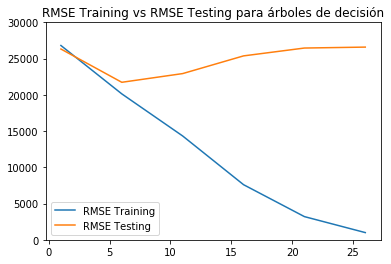

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(range(1,30, 5), rmses_train, label='RMSE Training')
plt.plot(range(1,30, 5), rmses_test, label='RMSE Testing')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.title("RMSE Training vs RMSE Testing para árboles de decisión")
plt.show()

Podemos ver aquí como el modelo presenta sobreajuste dado que a mayor complejidad (en este caso, mayor profundidad del árbol) más diferencia entre los resultados de training y testing. También observamos como la curva de testing decrece y luego vuelvo a crecer. El punto donde se minimiza está relacionado con el tradeoff entre sesgo y varianza.

## KNN

**Entrenamos un knn** y nuevamente medimos el **rmse** en el conjunto de testing


In [9]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train) 
y_predict = knn.predict(X_test)
np.exp(y_predict)
knn_mse = mean_squared_error (y_test, y_predict)
np.sqrt(knn_mse)

23750.461068233144

__Analizamos el cambio en el RMSE a medida que consideramos más vecinos para KNN, tanto en training como en testing.__

Para esto, **iteramos** incrementando de a uno el parámetro `n_neighbors` y **observamos** cómo impacta en el RMSE. 

**Creamos** dos arreglos `rmses_train` y `rmses_test` para ir guardando los **rmse** de cada profundidad

In [10]:

def root_mean_squared_error(y_train, y_predict):
    return np.sqrt(mean_squared_error(y_train, y_predict))

n_neighbors = list(range(1,30))
rmses_train = []
rmses_test = []
for k in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train) 
    y_predict = knn.predict(X_train)
    score = np.sqrt(mean_squared_error(y_train, y_predict))
    rmses_train.append(score)
    y_predict = knn.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_predict))
    rmses_test.append(score)
    
        

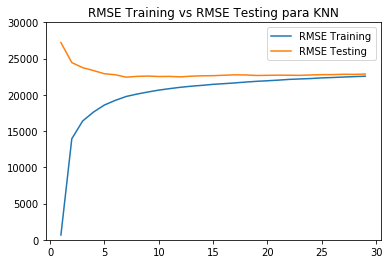

In [11]:
plt.plot(range(1,30, 1), rmses_train, label='RMSE Training')
plt.plot(range(1,30, 1), rmses_test, label='RMSE Testing')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.title("RMSE Training vs RMSE Testing para KNN")
plt.show()

__Calculamos el RMSE promedio de cross validation (10 folds) para un árbol de decisión de máxima profundidad 5.__

Dado que la implementación de scikit-learn usa el `neg_mean_squared_error` para calcular en cross validation, definamos el método nmsq2rmse para pasar de esa métrica al RMSE que venimos trabajando.

In [12]:
def nmsq2rmse(score):
    return np.sqrt(-score)

Usamos cross validation para analizar el resultado de estos parámetros para árboles de decisión. Recordemos que el resultado de cross validation es la performance en testing para cada partición. Una vez evaluado esto, podemos comparar entre modelos y cuando hayamos elegido el favorito, procedemos a ajustar y predecir.

**Calculamos** los `neg_scores` utilizando `cross_val_score` utilizando 10-fold cv. El parametro de `scoring` será `neg_mean_squared_error`

In [13]:
# Calculá en esta celda los cross_val_score
from sklearn.model_selection import cross_val_score

neg_score=cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

Para ver el resultado final, reentrenamos al regresor y mostramos en un dataframe la comparación entre los valores reales, los predichos y su diferencia

In [14]:
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_pred)

In [15]:
predicciones = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [16]:
predicciones.head(10)

,Valor real,Valor Pred,Dif(+/-)
0,149000.000,158000.000,9000.000
1,144900.000,75000.000,69900.000
2,100000.000,120000.000,20000.000
3,78822.360,84700.000,5877.640
4,129800.000,130600.000,800.000
5,82000.000,80000.000,2000.000
6,83000.000,85500.000,2500.000
7,110000.000,118000.000,8000.000
8,112000.000,170000.000,58000.000
9,80000.000,65000.000,15000.000


In [19]:
val_pred.describe()

count     1276.000
mean    121958.208
std      31727.178
min      61000.000
25%      95000.000
50%     123000.000
75%     148000.000
max     179900.000
dtype: float64